In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# datetime dtype
bike_df.datetime = pd.to_datetime(bike_df.datetime)

In [4]:
bike_df.datetime.dtype

dtype('<M8[ns]')

In [5]:
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour

In [6]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [7]:
# drop columns 
bike_df.drop(columns=['datetime', 'casual', 'registered'], inplace=True)

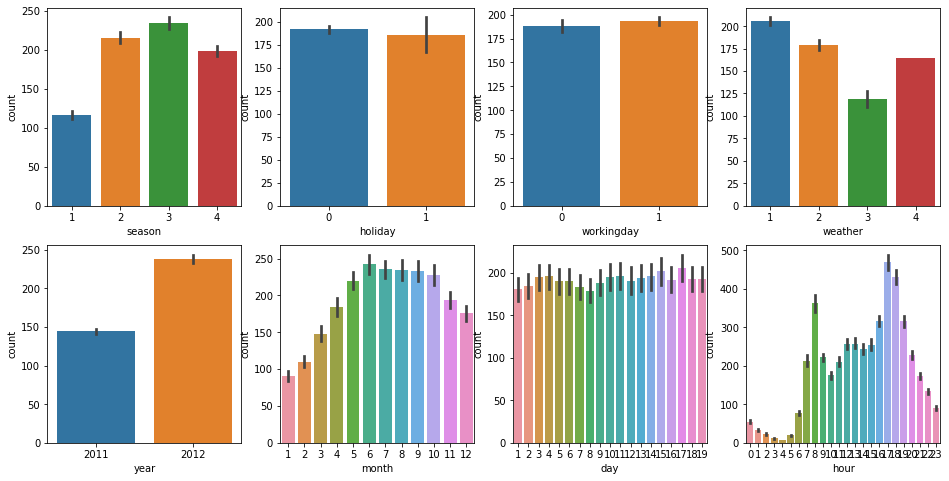

In [8]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour']
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# evaluation by RMSLE : log(y)에 대한 RMSE라고 생각하면 됨
# 평가함수 정의

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE:{0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))

### Feature Engineering

In [10]:
# 아무것도 안했을 때 평가 지표
X_features = bike_df.drop(['count'], axis=1, inplace=False)
y_target = bike_df['count']

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,test_size=0.3, 
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE:1.165, RMSE:140.900, MAE:105.924


In [12]:
# 아무것도 안했을 때 실제값과 예측값의 차이 비교
def get_error(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted count'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_error(y_test, pred, n_tops=5)

      real_count  predicted count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 실제 값과 예측 값의 차이가 매우 크다는 것을 확인할 수 있다. 

<AxesSubplot:>

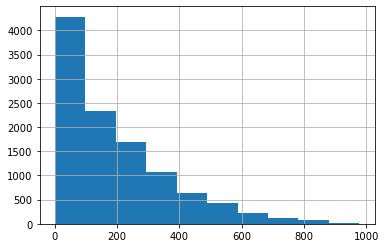

In [14]:
y_target.hist()

<AxesSubplot:>

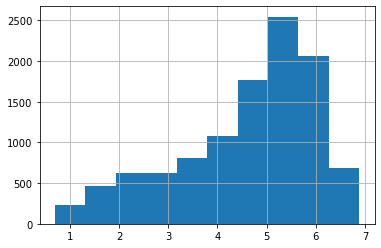

In [15]:
np.log1p(y_target).hist()

- target값을 로그 변환하니 정규분포형태는 아니지만 변환하기 전보다 왜곡 정도가 향상됨

In [16]:
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# target value 다시 원래 scale로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MAE:109.286


<AxesSubplot:>

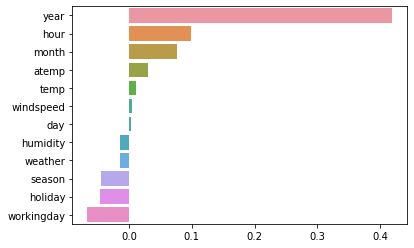

In [17]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [19]:
get_error(y_test_exp,pred_exp, n_tops=5)

      real_count  predicted count   diff
2199       201.0            913.0  712.0
3151       798.0            114.0  684.0
2314       766.0             96.0  670.0
412        745.0             78.0  667.0
2003       770.0            106.0  664.0


- target value log 변환 했는데도 RMSE는 오히려 늘어났고 실제값과 예측값의 차이가 더 커지기까지 했다... 

In [20]:
# 위 Barplot을 보면 categorical feature들의 coefficient가 지나치게 커졌음을 확인할 수 있다. 
# categorical variables에 대해 one-hot-encoding 시행

X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'day', 'hour', 'holiday', 
                                                       'workingday', 'season', 'weather'])

In [22]:
print(X_features.shape, y_target.shape)

(10886, 12) (10886,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                    test_size=0.3, random_state=0)

In [25]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)
models = [lr_reg, ridge_reg, lasso_reg]

In [26]:
def model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('####', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

for model in models:
    model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

#### LinearRegression ###
RMSLE:0.590, RMSE:97.687, MAE:63.382
#### Ridge ###
RMSLE:0.590, RMSE:98.529, MAE:63.893
#### Lasso ###
RMSLE:0.635, RMSE:113.219, MAE:72.803


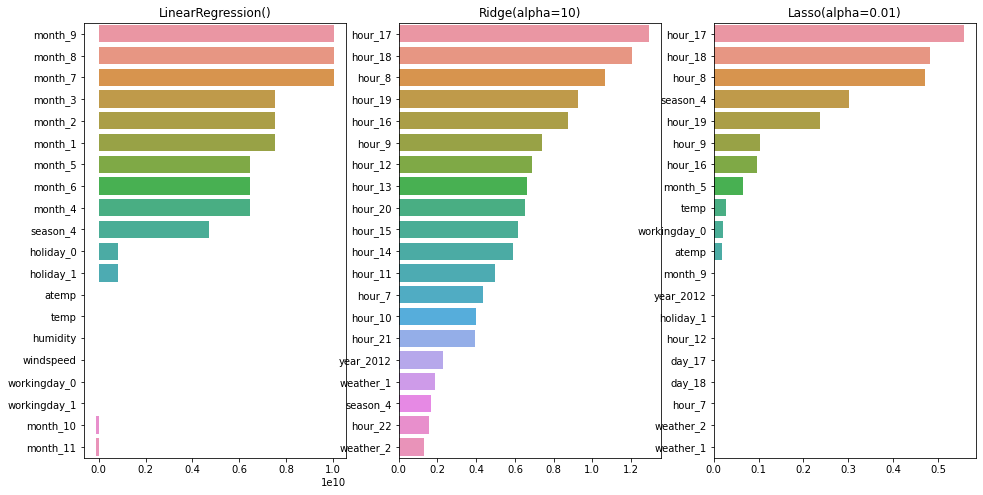

In [27]:
fig, axs = plt.subplots(figsize=(16,8), ncols=3, nrows=1)
for i, model in enumerate(models):
    row=1
    col=i%3
    coef=pd.Series(model.coef_, index = X_features_ohe.columns)
    coef_sort = coef.sort_values(ascending=False)[:20]
    sns.barplot(x=coef_sort.values, y= coef_sort.index, ax = axs[i])
    axs[i].set_title(model)

<AxesSubplot:>

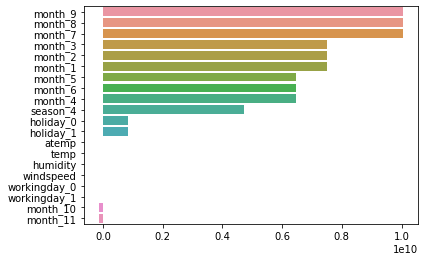

In [28]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

#### 회귀 트리 

In [29]:
# 회귀 트리 모델을 이용한 회귀 예측
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values)

#### RandomForestRegressor ###
RMSLE:0.094, RMSE:0.354, MAE:0.243
#### GradientBoostingRegressor ###
RMSLE:0.088, RMSE:0.330, MAE:0.236
#### XGBRegressor ###
RMSLE:0.094, RMSE:0.342, MAE:0.238
#### LGBMRegressor ###
RMSLE:0.086, RMSE:0.319, MAE:0.222
